### Libs preparation

In [1]:
import sys
import os

sys.path.append('..')

# **Questão 1**

Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dados

Tratamento dos dados

In [3]:
from amaprob.preprocessing.polynomial_features import PolynomialFeatures

data = pd.read_csv('../data/linear_regression_data.csv', header=None)
poly_1 = PolynomialFeatures(1)  # Aplicar atributos polinomiais com grau 1 retorna os dados com a primeira coluna constante

X = np.array([data.values[:, 0]]).T
X_processed = poly_1.transform(X)
y = np.array([data.values[:, 1]]).T

## Modelo

Definição do modelo, considerando as prioris sendo a média um vetor de zeros e a covariância uma matriz identidade, e assumindo um ruído gaussiano de valor $\sigma^2 = 0.5$

In [4]:
from amaprob.models.bayesian_linear_regression import BayesianLinearRegression

mean_prior = np.array([np.zeros(2)]).T
cov_prior = 10 * np.identity(2)

model = BayesianLinearRegression(mean_prior, cov_prior, noise=0.4)

## Plots - Dummy

Plotando o modelo "dummy"

In [5]:
def plot_blr_prediction(model, rng, poly):
    rng_processed = poly.transform(np.array([rng]).T)

    predictions = model.predict(rng_processed)

    upper_bound_model = predictions + 2*model.get_std(rng_processed, split=True)[0]
    lower_bound_model = predictions - 2*model.get_std(rng_processed, split=True)[0]

    upper_bound_noise = 2*model.get_std(rng_processed, split=True)[1] + upper_bound_model
    lower_bound_noise = -2*model.get_std(rng_processed, split=True)[1] + lower_bound_model

    plt.fill_between(rng, upper_bound_noise.T[0], lower_bound_noise.T[0], color='#eed8dd')
    plt.fill_between(rng, upper_bound_model.T[0], lower_bound_model.T[0], color='#ffe8dd')
    plt.scatter(X, y)
    plt.plot(rng, predictions, color='orange')
    plt.legend(['Incerteza (ruído)','Incerteza (modelo)', 'Dados', 'Função dada pelo modelo'])
    plt.title('Dados x Predição e Incerteza do modelo')

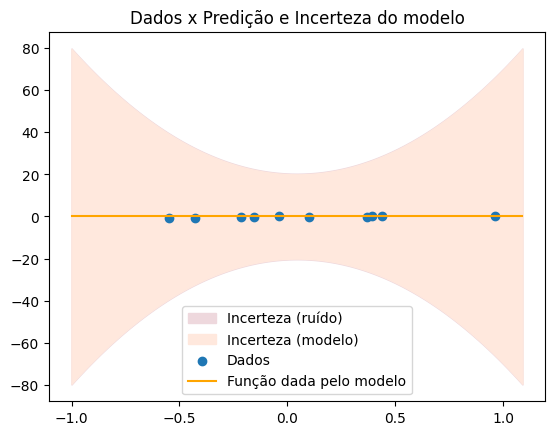

In [6]:
rng = np.arange(-1.0, 1.1, 0.01)

plot_blr_prediction(model, rng, poly_1)

Bônus: Plotando a distribuição dos pesos do modelo

In [7]:
from scipy.stats import multivariate_normal

def plot_weight_odblr(model, lb, up, step):
    x, y = np.mgrid[lb:up:step, lb:up:step]
    pos = np.dstack((x, y))
    rv = multivariate_normal(model.mean.T[0], model.covariance)
    plt.contourf(x, y, rv.pdf(pos), 100, cmap='inferno')
    plt.title('Distribuição normal dos pesos')
    plt.xlabel('w_1')
    plt.ylabel('w_2')

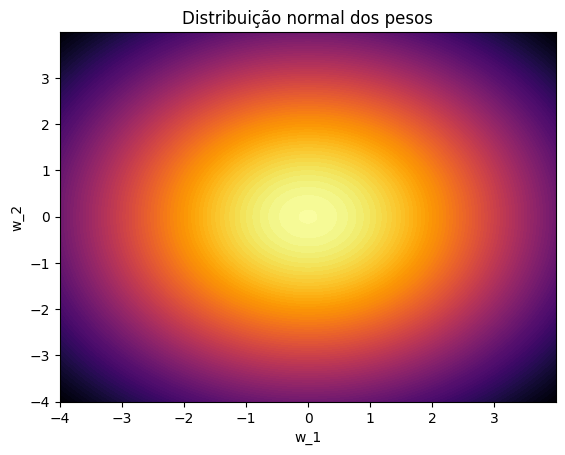

In [8]:
plot_weight_odblr(model, -4, 4, 0.01)

## Treinamento/Atualização

Atualizando o modelo

In [9]:
model.update(X_processed, y)

## Plots - Treinado

Plotando o modelo após a atualização

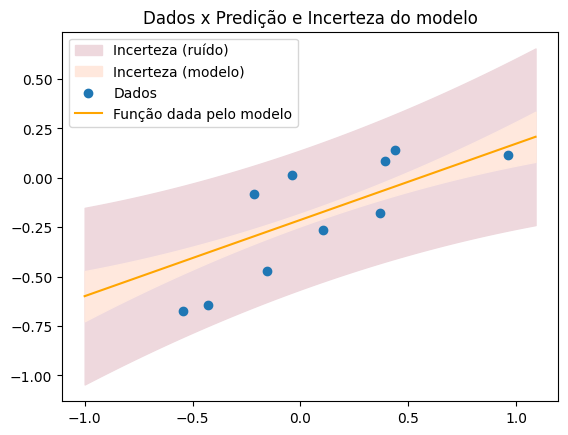

In [10]:
plot_blr_prediction(model, rng, poly_1)

Plotando a distribuição dos pesos do modelo

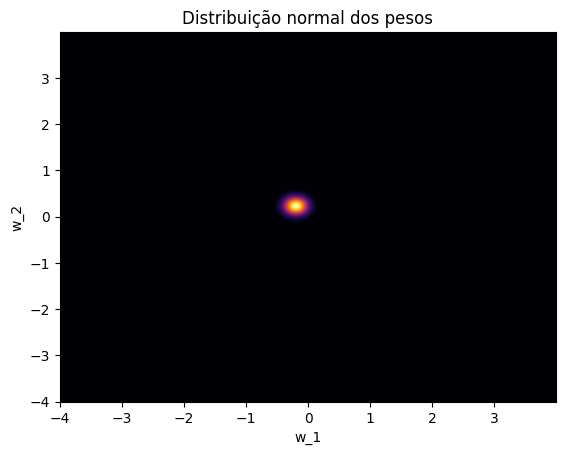

In [11]:
plot_weight_odblr(model, -4, 4, 0.01)

# **Questão 2**

## Dados

Tratamento dos dados

In [12]:
data = pd.read_csv('../data/polynomial_regression_data.csv', header=None)
poly_5 = PolynomialFeatures(5)

X = np.array([data.values[:, 0]]).T
X_processed = poly_5.transform(X)
y = np.array([data.values[:, 1]]).T

## Modelo

Definição do modelo, considerando as prioris sendo a média um vetor de zeros e a covariância uma matriz identidade, e assumindo um ruído gaussiano de valor $\sigma^2 = 1$

In [13]:
mean_prior = np.array([np.zeros(6)]).T
cov_prior = 10 * np.identity(6)

model = BayesianLinearRegression(mean_prior, cov_prior, noise = 0.4)

## Plots - Dummy

Plotando o modelo "dummy"

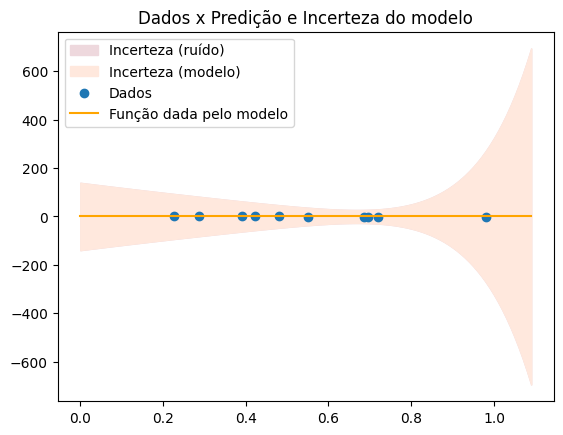

In [14]:
rng = np.arange(0.0, 1.1, 0.01)
plot_blr_prediction(model, rng, poly_5)

## Treinamento/Atualização

Atualizando o modelo

In [15]:
model.update(X_processed, y)

## Plots - Treinado

Plotando o modelo após a atualização

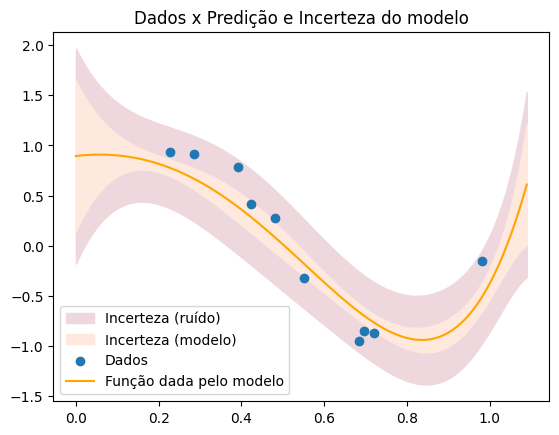

In [16]:
plot_blr_prediction(model, rng, poly_5)

# **Questão 3**

## Dados

Tratamento dos dados

In [31]:
data = pd.read_csv('../data/logistic_regression_data.csv', header=None)
poly_1 = PolynomialFeatures(1)

X = data.values[:, :-1]
X_processed = poly_1.transform(X)
y = np.array([data.values[:, -1]]).T

## Solução MAP

In [33]:
mean_prior = np.array([np.zeros(3)]).T
mean_prior[0][0] = 1.
cov_prior = 10 * np.identity(3)

In [36]:
from amaprob.models.irls_logistic_regression import IRLSLogisticRegression

prior_model = IRLSLogisticRegression(mean_prior, cov_prior)
prior_model.fit(X_processed, y)

A priori que alimentará a regressão logística bayesiana

In [ ]:
prior_model.w

array([[-0.15521768],
       [-5.22790334],
       [ 2.07040142]])

## Modelo final

In [ ]:
from amaprob.models.bayesian_logistic_regression import BayesianLogisticRegression

model = BayesianLogisticRegression(model.w, cov_prior)
model.fit(X_processed, y)

Visualizando a distribuição preditiva e os dados

In [115]:
def plot_decision_boundary(model, feat, data, labels, lb, up, step):
    x, y = np.meshgrid(np.linspace(lb, up, step), np.linspace(lb, up, step))
    x_in = np.c_[x.ravel(), y.ravel()]
    x_in_processed = feat.transform(x_in)
    y_pred = model.predict(x_in_processed)
    y_pred = y_pred.reshape(x.shape)
    
    plt.contourf(x, y, y_pred, 100, alpha=1, cmap='inferno')
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='inferno_r', marker='x')

    plt.title('Predição do modelo')
    plt.xlabel('Atributo 1')
    plt.ylabel('Atributo 2')

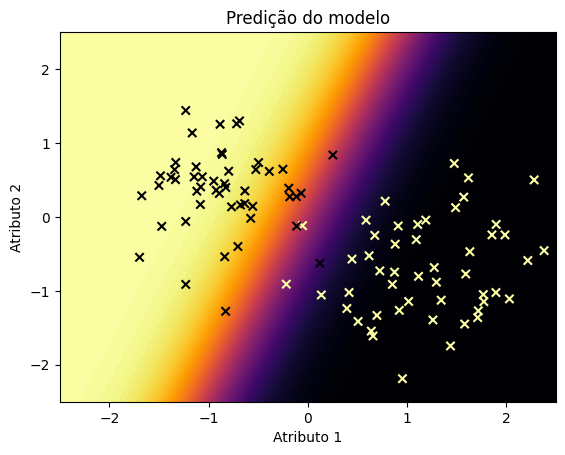

In [116]:
plot_decision_boundary(model, poly_1, X, y, -2.5, 2.5, 100)